In [1]:
import pandas as pd

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, cross_validate

from sklearn.preprocessing import MinMaxScaler

# **SIMPLE APPROACH**

# Load dataset

In [36]:
df = pd.read_csv('../raw_data/df_clean.csv')
df = df.drop(columns='Unnamed: 0')
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace=True)
df = df.rename(columns={"fb_costs": "facebook", "google_costs": "google", "tt_costs": "tiktok"})
df.head()

,orders,total_sales,facebook,fb_impressions,fb_clicks,google,google_impressions,google_clicks,tiktok,tt_impressions,tt_clicks
Day,,,,,,,,,,,
2021-07-01,10,414.85,257.01,36200,129,1.17,39,20,0.0,0,0
2021-07-02,6,229.95,250.30,33040,150,0.84,14,7,0.0,0,0
2021-07-03,10,459.89,248.59,33031,129,0.72,12,6,0.0,0,0
2021-07-04,17,508.36,258.05,37463,119,0.07,13,5,0.0,0,0
2021-07-05,13,399.88,257.47,35963,142,0.38,34,16,0.0,0,0


# Create a simple version for basic modelling

In [37]:
simple_df = df.drop(columns = ['fb_impressions', 'fb_clicks', 'google_impressions', 'google_clicks', 'tt_impressions', 'tt_clicks'])

In [38]:
X_simple = simple_df.drop(columns = ['orders', 'total_sales']) # 3 channels: facebook, google, and tiktok
y_simple = simple_df['total_sales'] # for now lets just use total_sales and exclude orders

In [39]:
simple_df

,orders,total_sales,facebook,google,tiktok
Day,,,,,
2021-07-01,10,414.85,257.01,1.17,0.0
2021-07-02,6,229.95,250.30,0.84,0.0
2021-07-03,10,459.89,248.59,0.72,0.0
2021-07-04,17,508.36,258.05,0.07,0.0
2021-07-05,13,399.88,257.47,0.38,0.0
...,...,...,...,...,...
2023-08-20,294,13616.97,2148.53,466.56,0.0
2023-08-21,356,15348.42,2210.01,400.58,0.0
2023-08-22,150,6054.53,1335.84,289.46,0.0


In [32]:
model = LinearRegression()

cross_val_score(model, X_simple, y_simple, cv=TimeSeriesSplit()).mean()

-0.4836074873027837

In [33]:
model.fit(X_simple, y_simple)
f"Intercept: {model.intercept_}, Coefficients: {model.coef_}"

'Intercept: 53.086951340116684, Coefficients: [ 1.56939293  9.11213351 -1.58373571]'

## sales = (1.57 * facebook) + (9.11 * google) + (-1.58 * tiktok) + 53.09

In [34]:
model.fit(X_simple, y_simple).score(X_simple, y_simple)

0.6998983933300782

# Visualization

ValueError: When stacked is True, each column must be either all positive or all negative. Column 'facebook' contains both positive and negative values

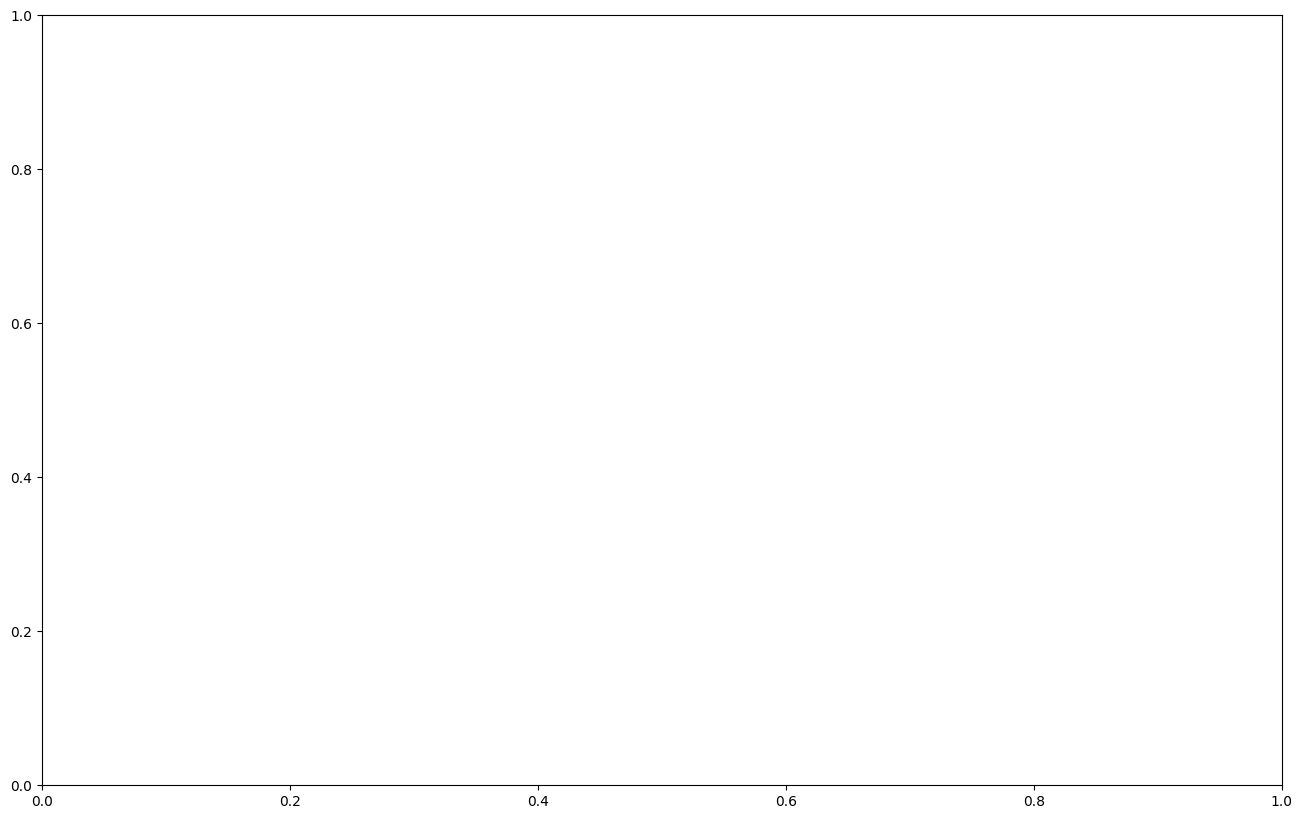

In [40]:
weights = pd.Series(
    model.coef_[0],
    index=X_simple.columns
    )

y = simple_df[['total_sales']]

base = model.intercept_

unadj_contributions = X_simple.mul(weights).assign(Base=base)


adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y['total_sales'], axis=0)
                    ) # contains all contributions for each day

ax = (adj_contributions[['facebook', 'google', 'tiktok']]
      .plot.area(
          figsize=(16, 10),
          linewidth=1,
          title='Predicted Sales and Breakdown',
          ylabel='Sales',
          xlabel='Date')
     )

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles[::-1], labels[::-1],
    title='Channels', loc="center left",
    bbox_to_anchor=(1.01, 0.5)
)


In [ ]:
unadj_contributions.sum(axis=1) # add up weighted contributions and intercept per row = sales per day

Day
2021-07-01     322.887155
2021-07-02     310.098525
2021-07-03     306.490330
2021-07-04     313.675942
2021-07-05     315.862211
                 ...     
2020-07-29     622.843699
2020-07-28     536.961036
2020-07-27     869.394146
2020-07-26    1048.748405
2020-07-25    1059.080157
Length: 880, dtype: float64

In [ ]:
unadj_contributions.div(unadj_contributions.sum(axis=1), axis=0) 
# divide each column by daily predicted sales $ to get predicted share of daily sales per channel

,facebook,google,Base
Day,,,
2021-07-01,1.136408,0.035234,-0.171642
2021-07-02,1.152381,0.026340,-0.178721
2021-07-03,1.157982,0.022843,-0.180825
2021-07-04,1.174513,0.002170,-0.176683
2021-07-05,1.163762,0.011698,-0.175460
...,...,...,...
2020-07-29,1.069778,0.019202,-0.088981
2020-07-28,1.024983,0.078229,-0.103213
2020-07-27,1.015207,0.048540,-0.063747


In [ ]:
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y_simple['total_sales'], axis=0)
                    ) # multiply by y_true to adjust contributions to actual total sales

In [ ]:
adj_contributions[adj_contributions['facebook'] < 0]

,facebook,google,Base
Day,,,
2021-08-27,-36.018213,-72.647774,283.605987
2021-08-28,-5608.736496,-571.817308,6390.473803
2021-11-21,-82.794918,-50.084678,335.839596
2021-11-22,-9.652622,-21.732724,154.835346
2021-11-23,-25.867814,-26.461656,132.299469
2021-11-24,-43.780316,-39.777720,178.518036
2021-11-26,-135.036615,-114.403775,509.420390
2021-12-04,-57.197480,-17.690730,102.888210
2021-12-05,-22.283694,-17.206303,251.459998


In [ ]:
adj_contributions[adj_contributions['google'] < 0]

,facebook,google,Base
Day,,,
2021-08-27,-36.018213,-72.647774,283.605987
2021-08-28,-5608.736496,-571.817308,6390.473803
2021-11-21,-82.794918,-50.084678,335.839596
2021-11-22,-9.652622,-21.732724,154.835346
2021-11-23,-25.867814,-26.461656,132.299469
2021-11-24,-43.780316,-39.777720,178.518036
2021-11-26,-135.036615,-114.403775,509.420390
2021-12-04,-57.197480,-17.690730,102.888210
2021-12-05,-22.283694,-17.206303,251.459998


In [ ]:
adj_contributions[adj_contributions['Base'] < 0]

,facebook,google,Base
Day,,,
2021-07-01,471.438926,14.616907,-71.205833
2021-07-02,264.990103,6.056787,-41.096890
2021-07-03,532.544537,10.505071,-83.159608
2021-07-04,597.075312,1.103107,-89.818419
2021-07-05,465.365021,4.677835,-70.162856
...,...,...,...
2023-08-20,5703.416551,8435.200086,-103.046638
2023-08-21,7160.763436,8839.924725,-125.778162
2023-08-22,2745.077322,4051.192807,-79.770129


In [ ]:
adj_contributions = (unadj_contributions
                     .div(unadj_contributions.sum(axis=1), axis=0)
                     .mul(y_simple['total_sales'], axis=0)
                    ) # contains all contributions for each day

# ROIs

## Facebook

### For each 1 euro we spend on facebook, we get 1.39 euros back

In [ ]:
sales_from_facebook = adj_contributions['facebook'].sum()
spendings_on_facebook = simple_df['facebook'].sum()
facebook_roi = sales_from_facebook / spendings_on_facebook
facebook_roi # 1.3866940463252655

1.3866940463252655

## Google

### For each 1 euro we spend on google, we get 9.96 euros back

In [ ]:
sales_from_google = adj_contributions['google'].sum()
spendings_on_google = simple_df['google'].sum()
google_roi = sales_from_google / spendings_on_google
google_roi # 9.958831484568629

9.958831484568629

# Issues with simple approach

* bad performance
* does not take saturation into account!
* optimizing is trivial, we cannot abandon all but one channel

# Exploratory Scaling

In [ ]:
minmax_scaler = MinMaxScaler()
X_simple_scaled = minmax_scaler.fit(X_simple).set_output(transform='pandas')
X_simple_scaled = minmax_scaler.transform(X_simple)